## 1. Modelos Generativos

a) Se pide definir la sección del encoder del VAE con 3 bloques convolucionales y un bloque fully conected, con una distribución Normal multivariada de 2 componentes para las variables latentes. Luego, se mostrará la arquitectura final que conforma al encoder.

In [1]:
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
img_rows, img_cols,channel = X_train.shape[1:]

Using TensorFlow backend.


In [2]:
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

b) A continuación, se nos pide definir la sección del decoder del VAE, con una tanda fully conected y con 3 bloque de la operación inversa a una convolución. Esta trabaja como se dijo anteriormente, de forma inversa, inviertiendo los papeles entre inputs y outputs, por lo que ahora en vez de disminuir las dimensiones, las aumentaremos. La implementación de unidades  de stride, rodea de ceros a las unidades, cambiando la naturaleza del input a zero-padded.

In [3]:
from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')


c) Se conectan las dos partes por medio de un sampleo implícito. Y se da a conocer la arquitectura final que compone al sistema.

In [4]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
# sample vector de la distribucion latente
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

d) Nos hacen elgir una de las dos funcionnes de pérdidas, para el entrenamiento de este VAE, ante lo cual se escogió binary_crossentropy. De regularizador se utiliza KL_divergence, esto es debido a que esta función tiene un mejor comportamiento al recibir distribuciones normales, ya que la extracción de la media y la desviación estandar es relativamente mas sencillo de obtener, disminuyendo la cantidad de computos.

In [5]:
from keras import backend as K
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

e) Se inicia el entrenamiento del modelo, estableciendo un batch_size de 16, optimizador "rmsprop" y 15 epochs.

In [6]:
batch_size = 16
epochs =  15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,shuffle=True,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

f:\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 58s 968us/step - loss: 2432570.6447 - val_loss: 151.6843
Epoch 2/15
60000/60000 [==============================] - 54s 896us/step - loss: 148.9890 - val_loss: 146.6336
Epoch 3/15
60000/60000 [==============================] - 54s 895us/step - loss: 146.1886 - val_loss: 145.7411
Epoch 4/15
60000/60000 [==============================] - 53s 878us/step - loss: 144.7782 - val_loss: 146.3197
Epoch 5/15
60000/60000 [==============================] - 53s 888us/step - loss: 143.9120 - val_loss: 143.5179
Epoch 6/15
60000/60000 [==============================] - 54s 892us/step - loss: 143.4219 - val_loss: 143.5767
Epoch 7/15
60000/60000 [==============================] - 53s 889us/step - loss: 143.0197 - val_loss: 142.3037
Epoch 8/15
60000/60000 [==============================] - 53s 889us/step - loss: 142.7591 - val_loss: 143.7470
Epoch 9/15
60000/60000 [==============================] - 

In [7]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)

<Figure size 640x480 with 2 Axes>

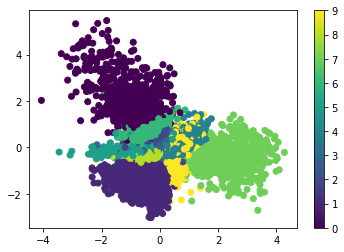

In [8]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

Como se aprecia en el gráfico, existe diferenciación para distintos números como es en este caso, ya que los clusters están bien definidos. Si nos tomamos el  tiempo para analizarlo más, se puede apreciar que los clusters solapados, pertenecen a los mismo números que presentaron problemas en la presentación de AE.

In [13]:
x_test2_encoded = encoder_log_var.predict(X_test, batch_size=batch_size)

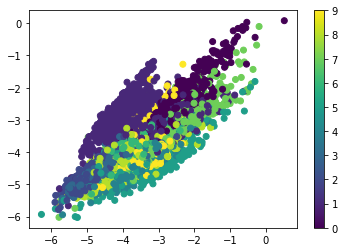

In [14]:
plt.scatter(x_test2_encoded[:, 0], x_test2_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

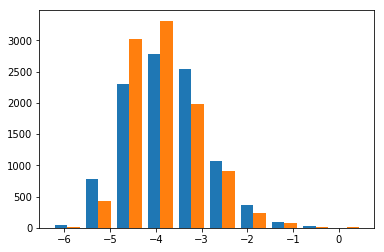

In [15]:
plt.hist(x_test2_encoded)
plt.show()

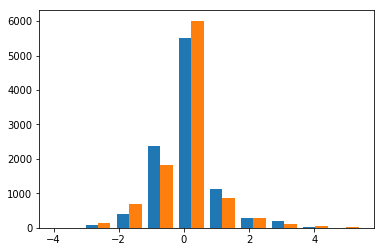

In [16]:
plt.hist(x_test_encoded)
plt.show()

g) Se generan datos nuevos artificialmente

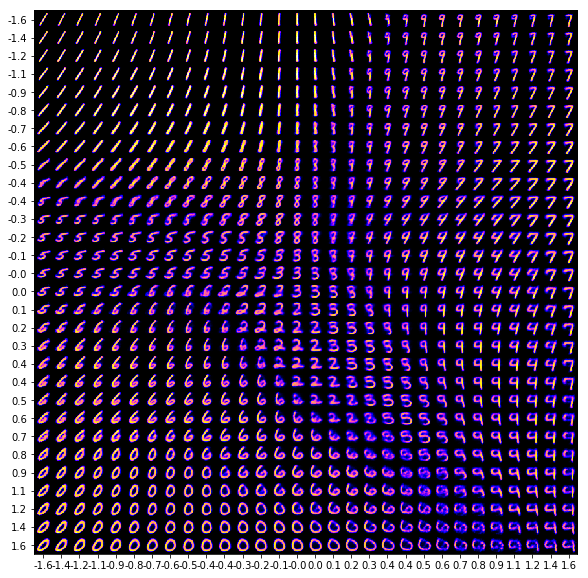

In [18]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

De lo mostrado se puede apreciar que los valoress mas nítidoz o resaltados, que pertenecen a las esquinas del cuadro, son los mismos que presentaban sus clusters marcados en el gráfico anterior, los cuales son los valores 1, 0, 4 y 7. Si bien el 4 no se presentaba con claridad en el gráfico, en esta muestra se aprecia que es el único que presenta problemas de generación y malinterpretación. 

h) Se cambia la distribución latente de los datos de z, por una distribución binomial con p=0.2

In [1]:
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
img_rows, img_cols,channel = X_train.shape[1:]

# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder.summary()

from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_binomial(shape=(K.shape(z_mean)[0], latent_dim), p=0.2)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
# sample vector de la distribucion latente
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [3]:
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [4]:
from keras import backend as K
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [5]:
batch_size = 16
epochs =  15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,shuffle=True,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

f:\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 56s 932us/step - loss: 159.8276 - val_loss: 150.0835
Epoch 2/15
60000/60000 [==============================] - 52s 868us/step - loss: 147.6709 - val_loss: 145.6990
Epoch 3/15
60000/60000 [==============================] - 52s 867us/step - loss: 144.8647 - val_loss: 143.9052
Epoch 4/15
60000/60000 [==============================] - 52s 868us/step - loss: 143.3954 - val_loss: 142.3354
Epoch 5/15
60000/60000 [==============================] - 52s 865us/step - loss: 142.6155 - val_loss: 143.9462
Epoch 6/15
60000/60000 [==============================] - 52s 867us/step - loss: 142.2564 - val_loss: 142.3892
Epoch 7/15
60000/60000 [==============================] - 52s 867us/step - loss: 142.2260 - val_loss: 142.3779
Epoch 8/15
60000/60000 [==============================] - 52s 868us/step - loss: 142.3944 - val_loss: 142.8309
Epoch 9/15
60000/60000 [==============================] - 52s 

In [6]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)

<Figure size 640x480 with 2 Axes>

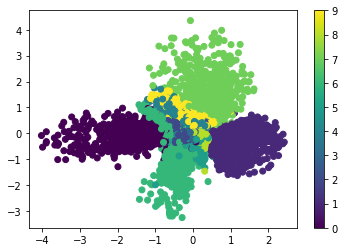

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

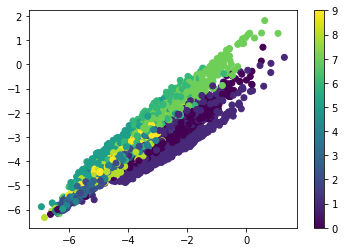

In [8]:
x_test2_encoded = encoder_log_var.predict(X_test, batch_size=batch_size)
plt.scatter(x_test2_encoded[:, 0], x_test2_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

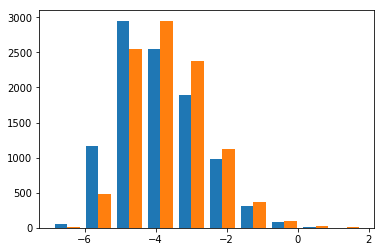

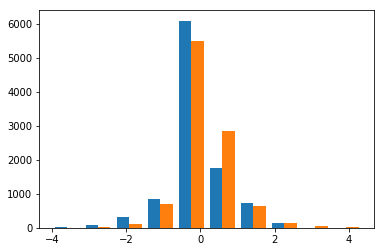

In [9]:
plt.hist(x_test2_encoded)
plt.show()
plt.hist(x_test_encoded)
plt.show()

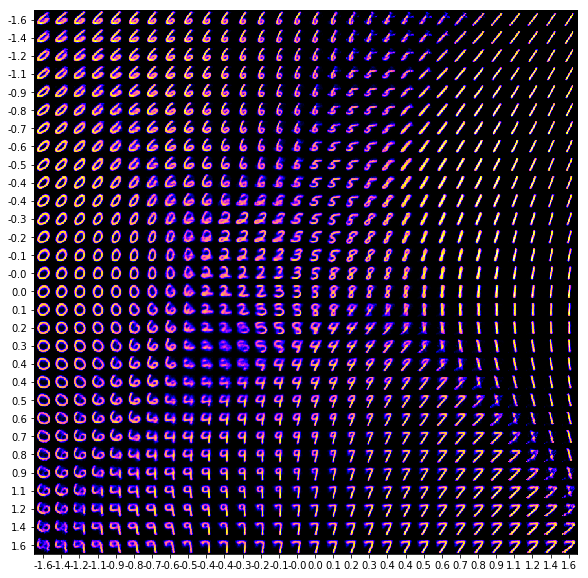

In [10]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

Si bien se presenta una mejor definición de la clusterización de los datos, loss números generados por este modelo, no son tan consistentes como los obtenidos en el punto anterior, pese a eso se presentan mejores definiciones en comparación al modelo anterior.

i) A continuación, se aumentará la dimensionalidad de las variables latentes.

In [1]:
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
img_rows, img_cols,channel = X_train.shape[1:]

# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 10
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
# sample vector de la distribucion latente
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

from keras import backend as K
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

Using TensorFlow backend.


In [2]:
batch_size = 16
epochs =  15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,shuffle=True,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

f:\python3.6\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 56s 936us/step - loss: 116.5823 - val_loss: 99.9748
Epoch 2/15
60000/60000 [==============================] - 53s 883us/step - loss: 98.3608 - val_loss: 94.8001
Epoch 3/15
60000/60000 [==============================] - 53s 881us/step - loss: 95.2206 - val_loss: 94.0507
Epoch 4/15
60000/60000 [==============================] - 53s 882us/step - loss: 93.4826 - val_loss: 93.8960
Epoch 5/15
60000/60000 [==============================] - 53s 884us/step - loss: 92.2376 - val_loss: 93.5127
Epoch 6/15
60000/60000 [==============================] - 53s 881us/step - loss: 91.3610 - val_loss: 90.9154
Epoch 7/15
60000/60000 [==============================] - 53s 883us/step - loss: 90.7017 - val_loss: 91.2488
Epoch 8/15
60000/60000 [==============================] - 53s 883us/step - loss: 90.1769 - val_loss: 90.1240
Epoch 9/15
60000/60000 [==============================] - 53s 881us/step - lo

In [3]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)

<Figure size 640x480 with 2 Axes>

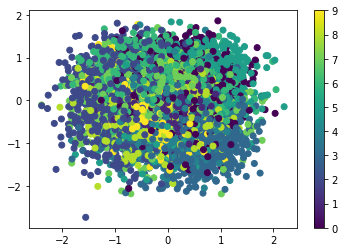

In [4]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

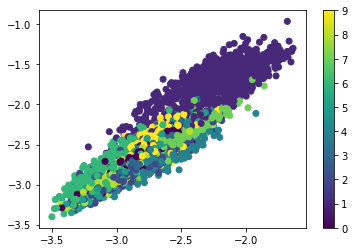

In [5]:
x_test2_encoded = encoder_log_var.predict(X_test, batch_size=batch_size)
plt.scatter(x_test2_encoded[:, 0], x_test2_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [6]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

ValueError: Error when checking : expected input_2 to have shape (10,) but got array with shape (2,)

In [ ]:
decoded_test = generator.predict(z_sample,batch_size=batch_size)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
